Root-finding Without Derivatives
================================

**References:**

- Section 1.5.2 of [Sauer](../references.html#Sauer)

- Section 2.3 of [Burden&Faires](../references.html#Burden-Faires) (the second half, on the Secant Method).

## Introduction

We have already seen one method for solving $f(x) = 0$ without needing to know any derivatives of $f$:
the [Bisection Method](root-finding-by-interval-halving-julia.ipynb), a.k.a. *Interval Halving*.
However, we have also seen that that method is far slower then Newton's Method.

Here we explore methods that are almost the best of both worlds:
about as fast as Newton's method but not needing derivatives.

The first of these is the Secant Method.
Later in this course we will see how this has been merged with the Bisection Method and
[Polynomial Interpolation](polynomial-collocation+approximation-python.ipynb)
to produce the current state-of-the-art approach;
only perfected in the 1960's.

In [1]:
# Enable graphics, basically with the Python package matplotlib.pyplot
using PyPlot

# Enable LaTeX math formatting in text strings, e.g. L"y=x^2"
using LaTeXStrings

In [2]:
n_plot_points = 100;

## Using Linear Approximation Without Derivatives

One quirk of the
[Bisection Method](root-finding-by-interval-halving-julia.ipynb)
is that it only used the sign of the values $f(a)$ and $f(b)$, not their magnitudes.
If one of these is far smaller than the other, one might guess that the root is closer to that end of the interval.
This leads to the idea of:
- starting with an interval $[a, b]$ known to contain a zero of $f$,
- connecting the two points $(a, f(a))$ and $(b, f(b))$ with a straight line, and
- finding the $x$-value $c$ where this line crosses the $x$-axis.
In the words, aproximating the function by a *secant line*, in place of the *tangent line* used in Newton's Method.

<a name="method-of-false-position"></a>
### First Attempt: The Method of False Position

The next step requires some care.
The first idea (from almost a millenium ago) was to use this new approximation $c$ as done with bisection:
check which of the intervals $[a, c]$ and $[c,b]$ has the sign change and use it as the new interval $[a, b]$;
this is called *The Method of False Position* (or *Regula Falsi*, since the academic world used latin in those days.)

The secant line between $(a, f(a))$ and $(b, f(b))$ is

$$
L(x) = \frac{f(a)(b-x) + f(b)(x-a)}{b-a}
$$

and its zero is at

$$
c = \frac{a f(b) - f(a) b}{f(b) - f(a)}
$$

This is easy to implement, and an example will show that it sort of works, but with a weakness that hampers it a bit:

In [3]:
function false_position(f, a, b; errorTolerance=1e-15, maxIterations=15, demoMode=false)
    """Solve f(x)=0 in the interval [a, b] by the Method of False Position.
    This code also illustrates a few ideas that I encourage, such as:
    - Avoiding infinite loops, by using for loops sand break
    - Avoiding repeated evaluation of the same quantity
    - Use of descriptive variable names
    - Use of "camelCase" to turn descriptive phrases into valid Python variable names
    - An optional "demonstration mode" to display intermediate results.
    """
    if demoMode
        println("Solving by the Method of False Position.")
    end;
    fa = f(a)
    fb = f(b)
    #c = b
    #errorBound = b - a
    for iteration in 1:maxIterations
        global c, errorBound  # To persist after the end of this for loop!
        if demoMode
            println("Iteration ", iteration)
        end;
        c = (a * fb - fa * b)/(fb - fa)
        fc = f(c)
        if fa * fc < 0
            b = c
            fb = fc  # N.B. When b is updated, so must be fb = f(b)
        else
            a = c
            fa = fc
        end;
        errorBound = b - a
        if demoMode
            println("The root is in interval [$(a), $(b)]")
            println("The new approximation is $(c) with error bound $(errorBound), backward error $(abs(fc))")
        end
        if errorBound < errorTolerance
            break
        end;
    end;
    # Whether we got here due to accuracy of running out of iterations,
    # return the information we have, including an error bound:
    root = c  # the newest value is probably the most accurate
    return [root errorBound]
end;

In [4]:
function f(x)
    return x - cos(x);
end;
a = -1;
b = 1;

In [5]:
root_errorBound = false_position(f, a, b, demoMode=true)
root = root_errorBound[1]
errorBound = root_errorBound[2]
print("\nThe Method of False Position gave approximate root $(root)")
print(" with estimate error $(errorBound), backward error $(abs(f(root)))")

Solving by the Method of False Position.
Iteration 1
The root is in interval [0.5403023058681398, 1]
The new approximation is 0.5403023058681398 with error bound 0.45969769413186023, backward error 0.31725090997825367
Iteration 2
The root is in interval [0.7280103614676172, 1]
The new approximation is 0.7280103614676172 with error bound 0.2719896385323828, backward error 0.018489394577603013
Iteration 3
The root is in interval [0.7385270062423998, 1]
The new approximation is 0.7385270062423998 with error bound 0.26147299375760025, backward error 0.0009339728812858272
Iteration 4
The root is in interval [0.7390571666782676, 1]
The new approximation is 0.7390571666782676 with error bound 0.2609428333217324, backward error 4.68048435270374e-5
Iteration 5
The root is in interval [0.7390837322783136, 1]
The new approximation is 0.7390837322783136 with error bound 0.2609162677216864, backward error 2.3446240340341262e-6
Iteration 6
The root is in interval [0.7390850630385933, 1]
The new appr

The good news is that the approximations are approaching the zero reasonably fast — far faster than bisection —
as indicated by the backward errors improving by a factor of better than ten at each iteration.

The bad news is that one end gets "stuck", so the interval does not shrink on both sides, and the error bound stays large.

This behavior is generic: with function $f$ of the same convexity on the interval $[a, b]$, the secant line will always cross on the same side of the zero, so that one end-point persists;
in this case, the curve is concave up, so the secant line always crosses to the left of the root, as seen in the following graphs.

In [6]:
function graph_false_position(f, a, b, maxIterations=3)
    """Graph a few iterations of the Method of False Position for solving f(x)=0 in the interval [a, b].
    """
    fa = f(a)
    fb = f(b)
    for iteration in 1:maxIterations
        c = (a * fb - fa * b)/(fb - fa)
        fc = f(c)
        abc = [a b c]
        # TODO: mind min, nac in julia!
        #left = min(abc)
        #right = max(abc)
        left = a
        right = b
        x = range(left, right, length=n_plot_points);
        figure(figsize=[16,6])
        grid(true)
        title("Iteration $(iteration) Method of False Position")
        xlabel("x")
        plot(x, f.(x))
        plot([left, right], [f(left), f(right)])  # the secant line
        plot([left, right], [0, 0], "k")  # the x-axis line
        plot(abc, f.(abc), "r*")
        show()  # The Windows version of JupytLab might need this command; it is harmless anyway.
        if fa * fc < 0
            b = c
            fb = fc  # N.B. When b is updated, so must be fb = f(b)
        else
            a = c
            fa = fc
        end;
    end;
end;

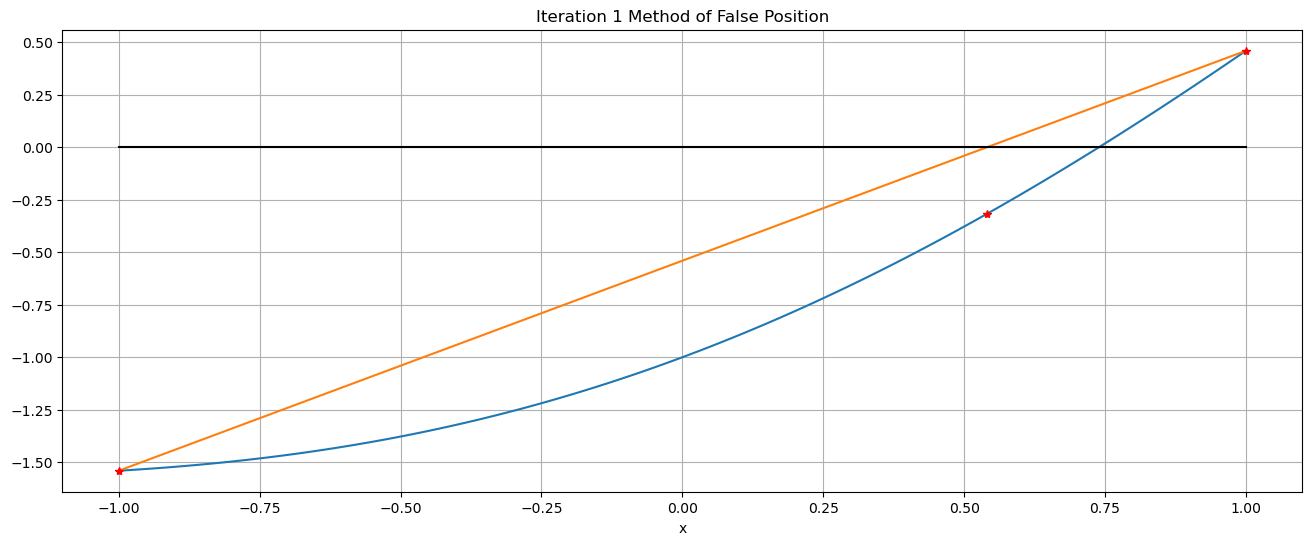

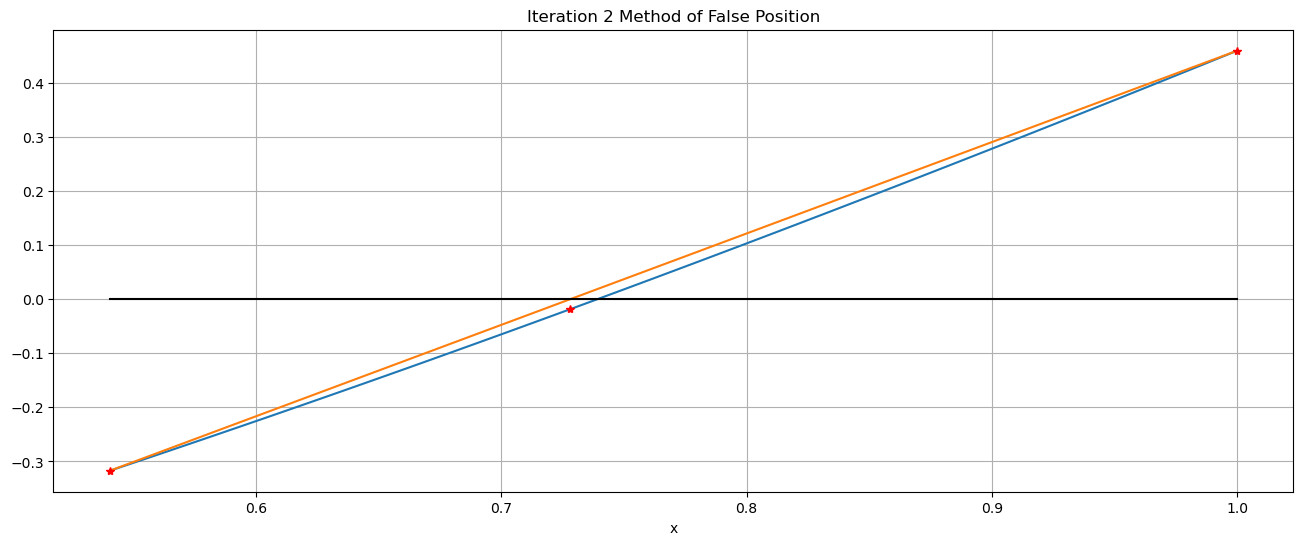

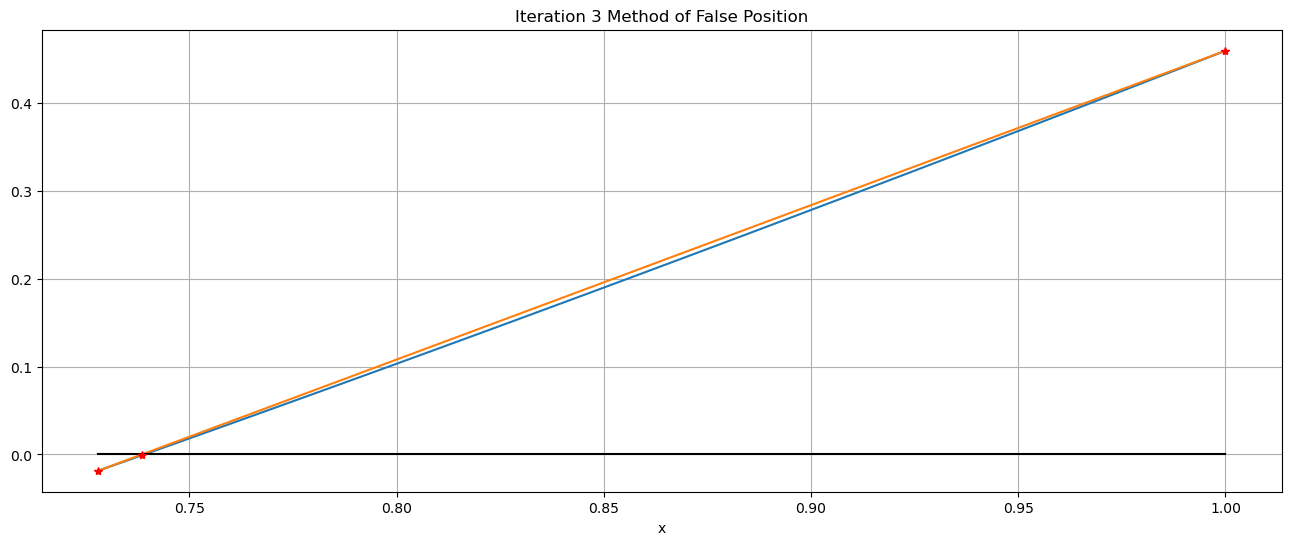

In [7]:
graph_false_position(f, a, b)

### Refinement: Alway Use the Two Most Recent Approximations — The Secant Method

The basic solution is to always discard the oldest approximation — at the cost of not always having the zero surrounded!
This gives the Secant Method.

For a mathemacal description, one typically enumerates the successive approximations as $x_0$, $x_1$, etc.,
so the notation above gets translated with $a \to x_{k-2}$, $b \to x_{k-1}$, $c \to x_{k}$;
then the formula becomes the recursive rule

$$
x_k = \frac{x_{k-2} f(x_{k-1}) - f(x_{k-2}) x_{k-1}}{f(x_{k-1}) - f(x_{k-2})}
$$

Two difference from above:
- previously we could assume that $a<b$, but now we do not know the order of the various $x_k$ values, and
- the root is not necessarily bewtween the two most recent values, so we no longer have tht simple error bound.
(In fact, we will see that the zero is typically surrounded two-thirds of the time!)

Instead, we use the *magnitude* of $b-a$ which is now $|x_k - x_{k-1}|$, and this is only an *estimate* of the error.
This is the same as used for Newton's Method; as there, it is still useful as a condition for ending the iterations and indeed tends to be pessimistic, so that we typically do one more iteration than needed — but it is not on its own a complete guarantee of having achieved the desired accuracy.

### Pseduo-code for a Secant Method Algorithm

Input function $f$, interval endpoints $x_0$ and $x_1$, an error tolerance $E_{tol}$, and an iteration limit $N$

for k from 2 to N:
<br>$\quad$ $\displaystyle x_k \leftarrow \frac{x_{k-2} f(x_{k-1}) - f(x_{k-2}) x_{k-1}}{f(x_{k-1}) - f(x_{k-2})}$
<br>$\quad$ Evaluate the error estimate $E_{est} \leftarrow |x_k - x_{k-1}|$
<br>$\quad$ if $E_{est} \leq E_{tol}$:
<br>$\quad\quad$ End the iterations
<br>$\quad$ else:
<br>$\quad\quad$ Go around another time
<br>end for
<br>Output the final $x_k$ as the approximate root and $E_{est}$ as an estimate of its absolute error.

### Python Code for this Secant Method Algorithm

We could write Python code that closely follows this notation, accumulating a list of the values $x_k$.

However, since we only ever need the two most recent values to compute the new one, we can instead just store these three,
in the same way that we recylced the variables `a`, `b` and `c`.
Here I use more descriptive names though:

In [8]:
function secant_method(f, a, b; errorTolerance=1e-15, maxIterations=15, demoMode=False)
    """Solve f(x)=0 in the interval [a, b] by the Secant Method."""
    if demoMode
        print("Solving by the Secant Method.")
    end;
    # Some more descriptive names
    x_older = a
    x_more_recent = b
    f_x_older = f(x_older)
    f_x_more_recent = f(x_more_recent)
    for iteration in 1:maxIterations
        global x_new, errorEstimate
        if demoMode
            println("\nIteration $(iteration):")
        end;
        x_new = (x_older * f_x_more_recent - f_x_older * x_more_recent)/(f_x_more_recent - f_x_older)
        f_x_new = f(x_new)
        (x_older, x_more_recent) = (x_more_recent, x_new)
        (f_x_older, f_x_more_recent) = (f_x_more_recent, f_x_new)
        errorEstimate = abs(x_older - x_more_recent)
        if demoMode
            println("The latest pair of approximations are $(x_older) and $(x_more_recent),")
            println("where the function's values are $(f_x_older) and $(f_x_more_recent) respectively.")
            println("The new approximation is $(x_new) with estimated error $(errorEstimate), backward error $(abs(f_x_new))")
        end;
        if errorEstimate < errorTolerance
            break
        end;
    end;
    # Whether we got here due to accuracy of running out of iterations,
    # return the information we have, including an error estimate:
    return [x_new  errorEstimate]
end;

In [9]:
root_errorEstimate = secant_method(f, a, b, demoMode=true)
root = root_errorEstimate[1]
errorEstimate = root_errorEstimate[2]

println("\nThe Secant Method gave approximate root $(root),")
print("with estimated error $(errorEstimate), backward error $(abs(f(root)))")

Solving by the Secant Method.
Iteration 1:
The latest pair of approximations are 1 and 0.5403023058681398,
where the function's values are 0.45969769413186023 and -0.31725090997825367 respectively.
The new approximation is 0.5403023058681398 with estimated error 0.45969769413186023, backward error 0.31725090997825367

Iteration 2:
The latest pair of approximations are 0.5403023058681398 and 0.7280103614676172,
where the function's values are -0.31725090997825367 and -0.018489394577603013 respectively.
The new approximation is 0.7280103614676172 with estimated error 0.18770805559947745, backward error 0.018489394577603013

Iteration 3:
The latest pair of approximations are 0.7280103614676172 and 0.7396270126307336,
where the function's values are -0.018489394577603013 and 0.0009070044004072519 respectively.
The new approximation is 0.7396270126307336 with estimated error 0.011616651163116387, backward error 0.0009070044004072519

Iteration 4:
The latest pair of approximations are 0.7396

Alternatively, get can try to get a version of `secant` from the module (a.k.a. package) `numericalMethodsJulia`

**HOWEVER,** the following is not working yet!

In [10]:
# If we are creating this module (a.k.a. package) "numericalMethodsModule" we need:
    #import Pkg
# Then create a folder for it:
    #Pkg.generate("numericalMethodsJulia")
# Then within folder numericalMethodsJulia/src/,
# replace the stub file "numericalMethodsJulia.jl" by the real thing.

In [11]:
# Once the package exists, when we use it for the first time we need
    #import Pkg
    #Pkg.add("numericalMethodsJulia")
# This "Pkg.add" is not working yet

In [12]:
# But after all that one-time setup, we usually just need
#using numericalMethodsJulia
# to access items by full name like "numericalMethodsModule.secant", or
#    using numericalMethodsJulia: secant
# to access items by just as named within the module, like "secant".

In [13]:
#root_errorEstimate = secant(f, a, b, demoMode=true)
#root = root_errorEstimate[1]
#errorEstimate = root_errorEstimate[2]
#
#println("\nThe Secant Method gave approximate root $(root),")
#print("with estimated error $(errorEstimate), backward error $(abs(f(root)))")

In [14]:
function graph_secant_method(f, a, b, maxIterations=5)
    """Graph a few iterations of the Secant Method for solving f(x)=0 in the interval [a, b]."""
    x_older = a
    x_more_recent = b
    f_x_older = f(x_older)
    f_x_more_recent = f(x_more_recent)
    for iteration in 1:maxIterations
        #global x_new, errorEstimate
        x_new = (x_older * f_x_more_recent - f_x_older * x_more_recent)/(f_x_more_recent - f_x_older)
        f_x_new = f(x_new)
        # TODO: find min, max in julia!
        latest_three_x_values = [x_older x_more_recent x_new]
        #left = nmin(latest_three_x_values)
        #right = max(latest_three_x_values)
        left = a
        right = b
        x = range(left, right, length=n_plot_points);
        figure(figsize=[16,6])
        grid(true)
        title("Iteration $(iteration), Secant Method")
        xlabel("x")
        plot(x, f.(x))
        plot([left, right], [f(left), f(right)])  # the secant line
        plot([left, right], [0, 0], "k")  # the x-axis line
        plot(latest_three_x_values, f.(latest_three_x_values), "r*")
        #show()
        x_older = x_more_recent
        f_x_older = f_x_more_recent
        x_more_recent = x_new
        f_x_more_recent = f_x_new
        errorEstimate = abs(x_older - x_more_recent)
    end;
end;

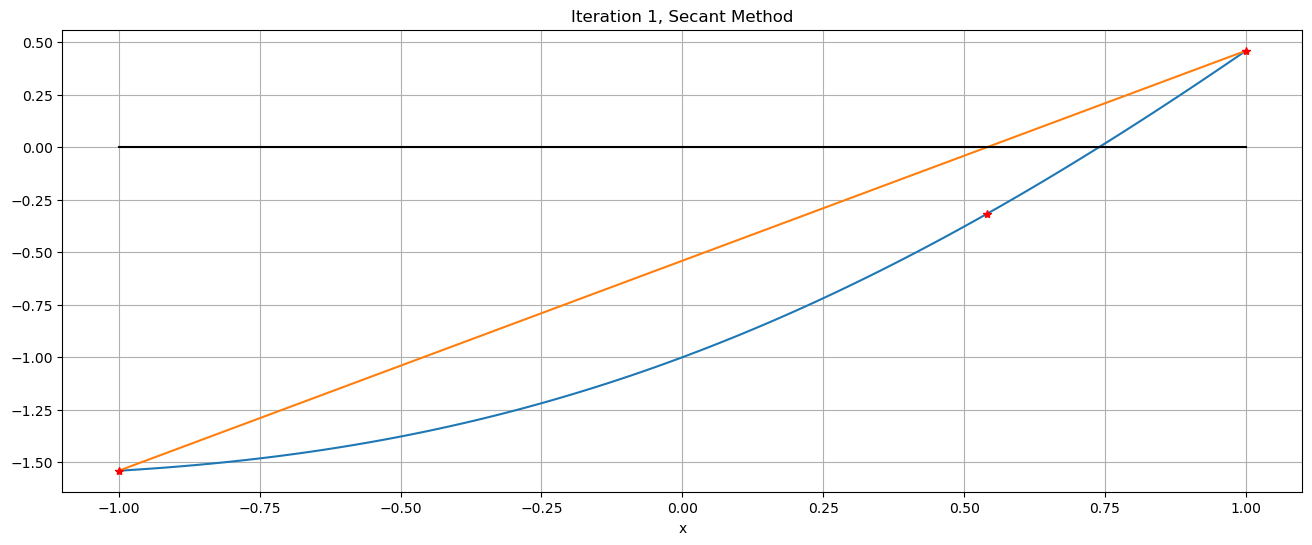

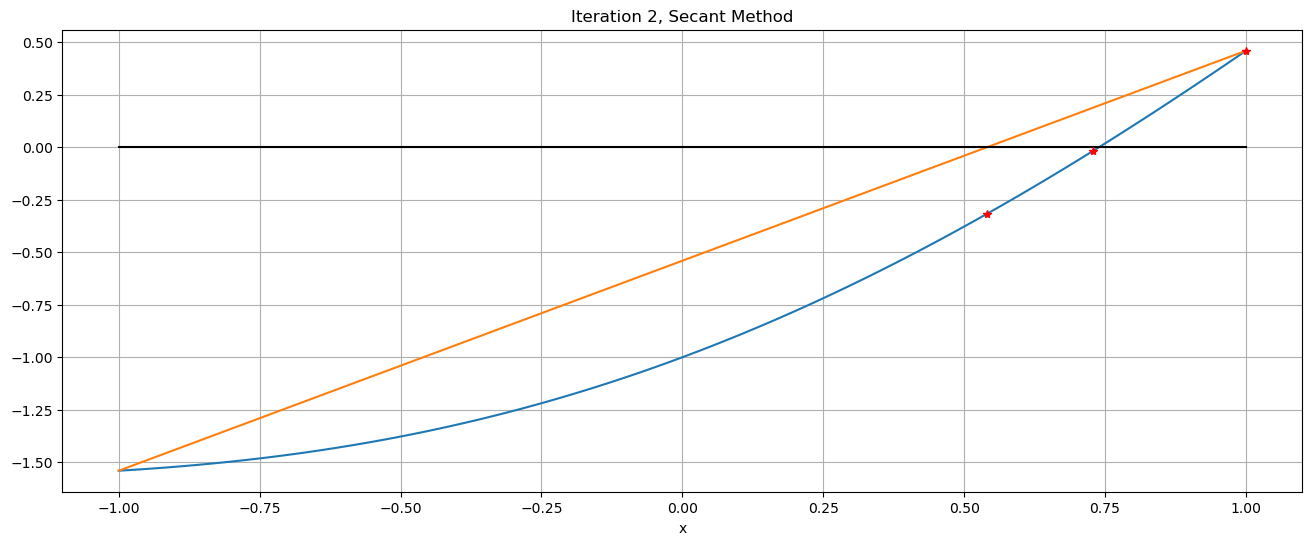

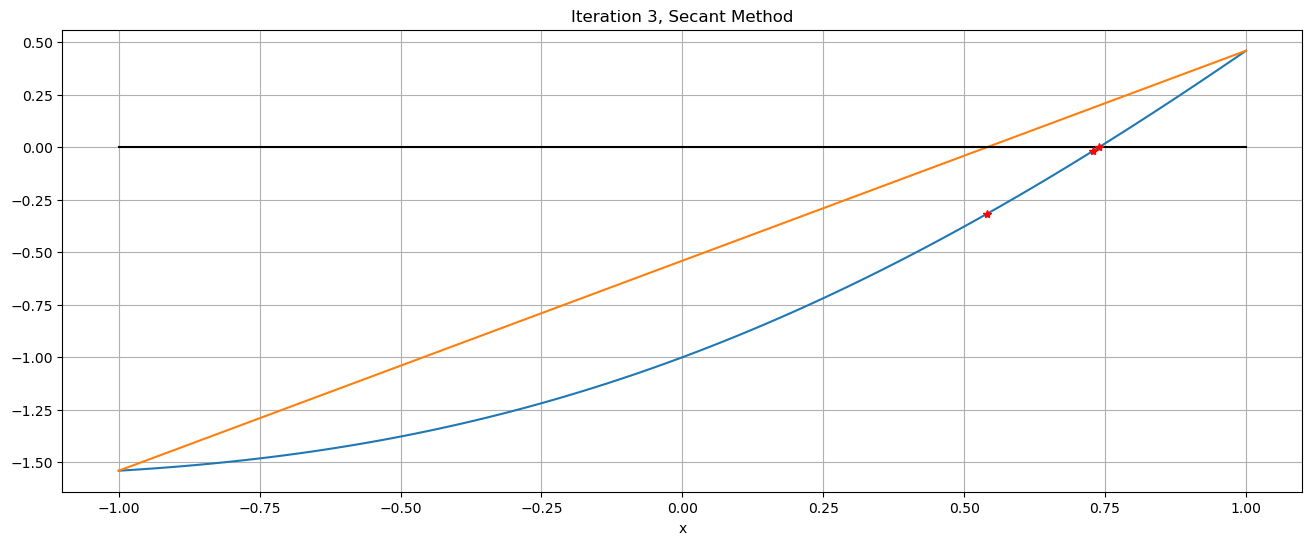

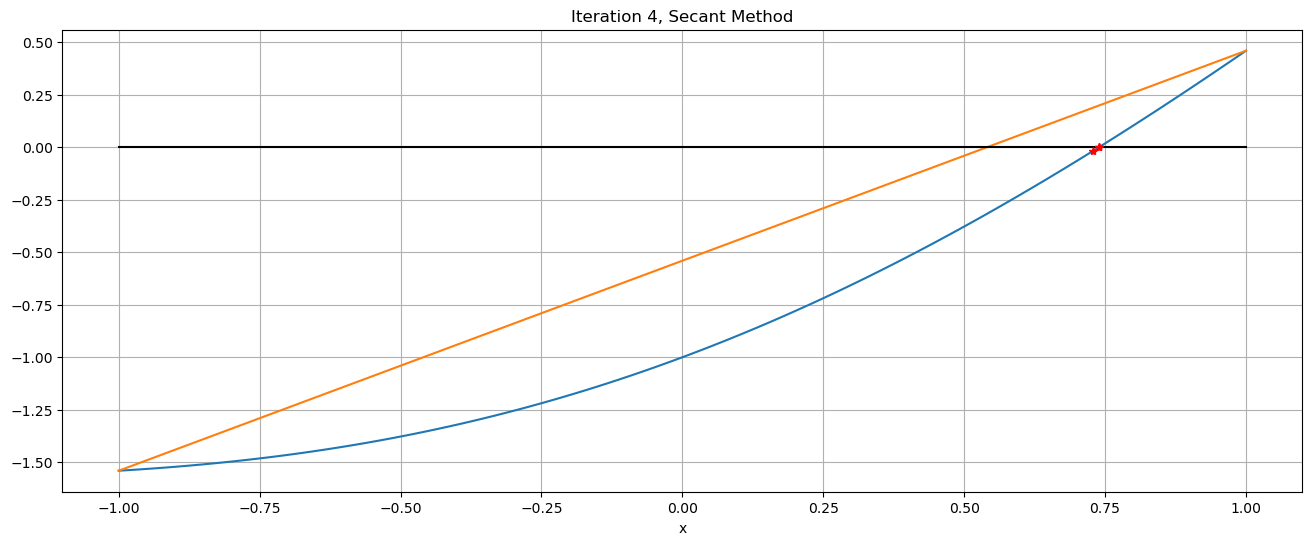

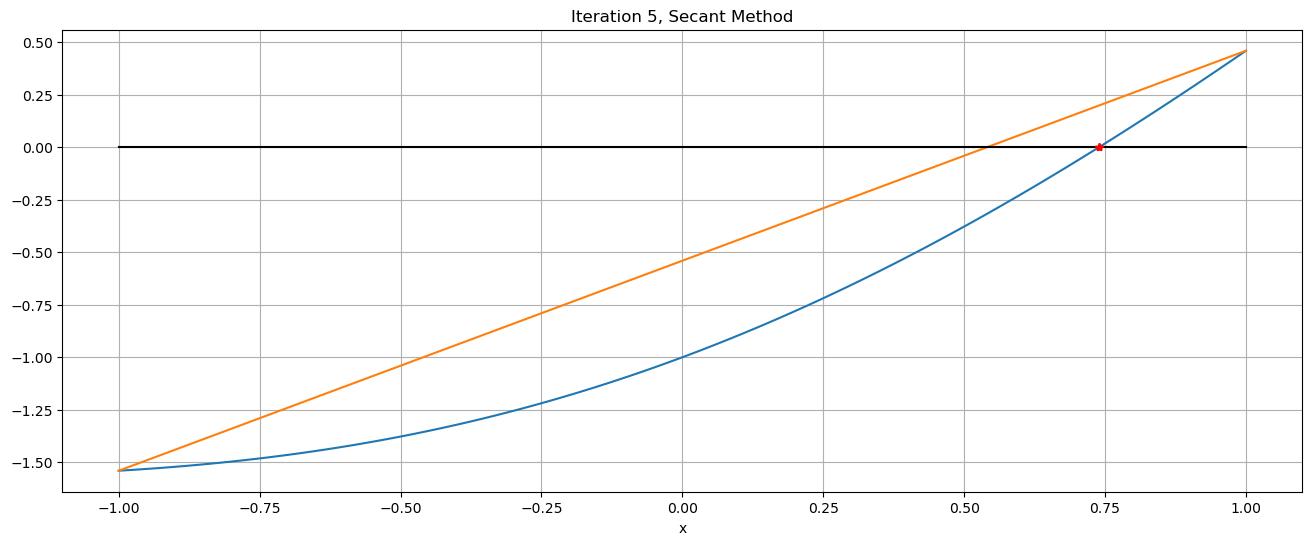

In [15]:
graph_secant_method(f, a, b)

### Observations

- This converges faster than the [Method of False Position](#method-of-false-position) (and far faster than Bisection).
- The majority of iterations do have the root surrounded (sign-change in $f$), but every third one — the second and fifth — do not.
- Comparing the error estimate to the backward error, the error estmte is in fact quite pessimistic (and so fairly trustworthy); in fact, it is typically of similar size to the backward error at the previous iteration.

The last point is a quite common occurence: the available error estimates are often "trailing indicators",
closer to the error in the previous approximation in an iteration.
For example, recall that we saw the same thing with Newton's Method when we used $|x_k - x_{k-1}|$ to estimate the error $E_k := x_k - r$ and saw that it is in fact closer to the previous error, $E_{k-1}$.

---

This work is licensed under [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/)